In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn_quantile import RandomForestQuantileRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.base import clone

In [2]:
def mu(x, a, b):
    return a + b*x

def generate_data(a, b, n):
    x = np.random.uniform(-5, 5, n)
    s = 2
    y = mu(x, a, b) + s*np.random.randn(n)
    return np.column_stack((x, y))

In [12]:
R = 500
n_train, n_cal, n_test = 1000, 1500, 1500
n = n_cal + n_test

D_train = generate_data(1, -1, n_train)
X_train, Y_train = D_train[:, 0], D_train[:, 1]

alpha = 0.1

In [13]:
def absolute_residual_score(x, y, model):
    return np.abs(y - model.predict(x).flatten())

def locally_weighted_score(x, y, mu_model, sigma_model):
    return np.abs(y - mu_model.predict(x).flatten())/sigma_model.predict(x).flatten()

# def quantile_score(x, y, lower_q_model, upper_q_model):
#     l = lower_q_model.predict(x) - y
#     u = y - upper_q_model.predict(x)
#     return np.maximum(l, u)

def quantile_score(x, y, q_model, t):
    model_pred = q_model.predict(x, target=t, sample_size=1000)
    l = model_pred[0] - y
    u = y - model_pred[1]
    return np.maximum(l, u)

def check_coverage(alpha, n, y, y_lower, y_upper, q_cal):
    if q_cal >= n+1:
        return 1
    else:
        return np.mean((y <= y_upper) & (y >= y_lower))
    
q_cal = int(np.ceil((1-alpha)*(n_cal + 1)))

In [14]:
# Split CP with random forests
n_estimators = [100, 150, 200]
max_depth = [5, 10, 15]
min_samples_split = [2, 6, 10]

param_grid = {"n_estimators": n_estimators,
              "max_depth": max_depth,
              "min_samples_split": min_samples_split}

model_RF = GridSearchCV(estimator = RandomForestRegressor(),
                     param_grid= param_grid,
                     cv = 5,
                     n_jobs=4)

model_RF.fit(X_train.reshape(-1, 1), Y_train.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_split': [2, 6, 10],
                         'n_estimators': [100, 150, 200]})

In [ ]:
abs_errors = absolute_residual_score(X_train.reshape(-1, 1), Y_train, model_RF)

sigma_model = GridSearchCV(estimator = RandomForestRegressor(),
                     param_grid= param_grid,
                     cv = 5,
                     n_jobs=4)
sigma_model.fit(X_train.reshape(-1, 1), abs_errors.ravel())

In [ ]:
import torch
from engression import engression

X_train_tensor = torch.tensor(X_train.reshape(-1,1), dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.reshape(-1,1), dtype=torch.float32)
model = engression(
    X_train_tensor,
    Y_train_tensor,
    lr=0.01,
    num_epochs=500,
    batch_size=128,
)

In [ ]:
D = generate_data(1, -1, n)
D_cal = D[:n_cal,:]
D_test = D[n_cal:(n_cal + n_test),:]
X_cal, Y_cal = D_cal[:, 0], D_cal[:, 1]
X_test_Q, Y_test_Q = D_test[:, 0], D_test[:, 1]

X_cal_tensor = torch.tensor(X_cal.reshape(-1,1), dtype=torch.float32)
Y_cal_tensor = torch.tensor(Y_cal.reshape(-1,1), dtype=torch.float32)
X_test_Q_tensor = torch.tensor(X_test_Q.reshape(-1,1), dtype=torch.float32)
Y_test_Q_tensor = torch.tensor(Y_test_Q.reshape(-1,1), dtype=torch.float32)

In [ ]:
# 
# q_quantile = np.sort(scores_Q.flatten())[q_cal - 1]
# y_upper_Q = Y_pred_Q + q_quantile
# y_lower_Q = Y_pred_Q - q_quantile

In [ ]:
Y_pred_Q = model.predict(X_test_Q_tensor, target=[alpha/2,1-alpha/2], sample_size=300)
Y_pred_Q_upper = Y_pred_Q[1]
Y_pred_Q_lower = Y_pred_Q[0]

scores_Q = quantile_score(X_cal_tensor, Y_cal_tensor, model, [alpha/2, 1-(alpha/2)])
q_quantile = np.sort(scores_Q.flatten())[q_cal - 1]
y_upper_Q = (Y_pred_Q_upper + q_quantile).ravel()
y_lower_Q = (Y_pred_Q_lower - q_quantile).ravel()

In [ ]:
plt.scatter(X_test_Q, Y_test_Q)
plt.plot(X_test_Q[np.argsort(X_test_Q)], Y_pred_Q_lower[np.argsort(X_test_Q)], linestyle="dashed", color="black")
plt.plot(X_test_Q[np.argsort(X_test_Q)], Y_pred_Q_upper[np.argsort(X_test_Q)], linestyle="dashed", color="black")
plt.fill_between(X_test_Q[np.argsort(X_test_Q)], y_lower_Q[np.argsort(X_test_Q)], y_upper_Q[np.argsort(X_test_Q)], color="red", alpha = 0.5, label="Prediction interval")

In [ ]:
torch.mean((Y_test_Q_tensor.ravel() >= y_lower_Q) & (Y_test_Q_tensor.ravel() <= y_upper_Q), dtype=torch.float32)

In [ ]:
cov_Q = np.zeros((R, ))
for r in range(R):
    D = generate_data(1, -1, n)
    D_cal = D[:n_cal,:]
    D_test = D[n_cal:(n_cal + n_test),:]
    X_cal, Y_cal = D_cal[:, 0], D_cal[:, 1]
    X_test_Q, Y_test_Q = D_test[:, 0], D_test[:, 1]

    X_cal_tensor = torch.tensor(X_cal.reshape(-1,1), dtype=torch.float32)
    Y_cal_tensor = torch.tensor(Y_cal.reshape(-1,1), dtype=torch.float32)
    X_test_Q_tensor = torch.tensor(X_test_Q.reshape(-1,1), dtype=torch.float32)
    Y_test_Q_tensor = torch.tensor(Y_test_Q.reshape(-1,1), dtype=torch.float32)

    Y_pred_Q = model.predict(X_test_Q_tensor, target=[alpha/2,1-alpha/2], sample_size=500)
    Y_pred_Q_upper = Y_pred_Q[1]
    Y_pred_Q_lower = Y_pred_Q[0]

    scores_Q = quantile_score(X_cal_tensor, Y_cal_tensor, model, [alpha/2, 1-(alpha/2)])
    q_quantile = np.sort(scores_Q.flatten())[q_cal - 1]
    y_upper_Q = (Y_pred_Q_upper + q_quantile).ravel()
    y_lower_Q = (Y_pred_Q_lower - q_quantile).ravel()

    cov_Q[r] = torch.mean((Y_test_Q_tensor.ravel() >= y_lower_Q) & (Y_test_Q_tensor.ravel() <= y_upper_Q), dtype=torch.float32)
    if r % 10 == 0:
        print(str(cov_Q[r]))

In [15]:
cov_RF = np.zeros((R, ))
for r in range(R):
    D = generate_data(1, -1, n)
    D_cal = D[:n_cal,:]
    D_test = D[n_cal:(n_cal + n_test),:]
    X_cal, Y_cal = D_cal[:, 0], D_cal[:, 1]
    X_test_RF, Y_test_RF = D_test[:, 0], D_test[:, 1]

    scores_RF = absolute_residual_score(X_cal.reshape(-1, 1), Y_cal, model_RF)
    Y_pred_RF = model_RF.predict(X_test_RF.reshape(-1, 1)).flatten()
    q_absolute = np.sort(scores_RF.flatten())[q_cal - 1]
    y_upper_RF = Y_pred_RF + q_absolute
    y_lower_RF = Y_pred_RF - q_absolute

    cov_RF[r] = check_coverage(alpha, n_cal, Y_test_RF, y_lower_RF, y_upper_RF, q_cal)

(array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.002, 0.   , 0.   , 0.   , 0.006,
        0.   , 0.   , 0.002, 0.002, 0.002, 0.006, 0.004, 0.004, 0.01 ,
        0.008, 0.004, 0.008, 0.008, 0.006, 0.008, 0.004, 0.002, 0.006,
        0.018, 0.008, 0.016, 0.01 , 0.008, 0.012, 0.016, 0.022, 0.026,
        0.024, 0.02 , 0.016, 0.016, 0.018, 0.034, 0.016, 0.044, 0.014,
        0.028, 0.026, 0.026, 0.012, 0.024, 0.012, 0.02 , 0.036, 0.028,
        0.012, 0.022, 0.018, 0.02 , 0.026, 0.024, 0.018, 0.018, 0.018,
        0.016, 0.012, 0.014, 0.02 , 0.012, 0.012, 0.008, 0.014, 0.014,
        0.012, 0.004, 0.002, 0.008, 0.008, 0.01 , 0.002, 0.002, 0.004,
        0.   , 0.004, 0.   , 0.002, 0.002, 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
      

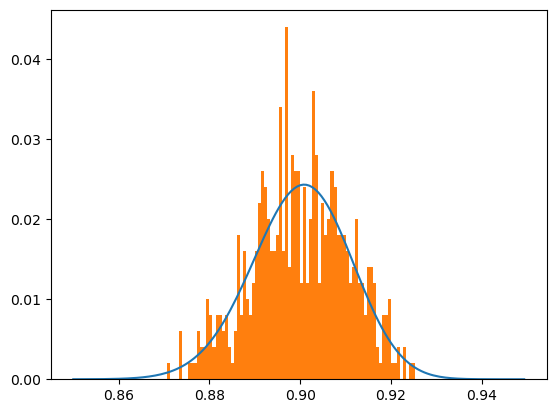

In [16]:
from scipy.stats import beta, betabinom
N = n_cal
N_val = n_test
l = np.ceil((1-alpha)*(N+1))
a = l
b = N+1-l
# x = np.linspace(betabinom.ppf(0.001,N_val, a,b),beta.ppf(0.999,N_val, a,b), 1000)

x = np.array(range(int(N_val*(0.85)),int(N_val*0.95)))
rv = betabinom(N_val,a, b)
plt.plot(x/N_val, rv.pmf(x))
plt.hist(cov_RF, bins=x/N_val, weights=(1/R)*np.ones_like(cov_RF))


In [17]:
np.mean(cov_RF)

np.float64(0.8996386666666667)

In [ ]:
cov_LW = np.zeros((R, ))
for r in range(R):
    D = generate_data(1, -1, n)
    D_cal = D[:n_cal,:]
    D_test = D[n_cal:(n_cal + n_test),:]
    X_cal, Y_cal = D_cal[:, 0], D_cal[:, 1]
    X_test_LW, Y_test_LW = D_test[:, 0], D_test[:, 1]

    scores_LW = locally_weighted_score(X_cal.reshape(-1, 1), Y_cal, model_RF, sigma_model)
    Y_pred_LW = model_RF.predict(X_test_LW.reshape(-1, 1)).flatten()
    sigma_pred = sigma_model.predict(X_test_LW.reshape(-1,1)).flatten()

    q_weighted = np.sort(scores_LW.flatten())[q_cal - 1]
    y_upper_W = Y_pred_LW + q_weighted * sigma_pred
    y_lower_W = Y_pred_LW - q_weighted * sigma_pred

    cov_LW[r] = check_coverage(alpha, n_cal, Y_test_LW, y_lower_W, y_upper_W, q_cal)

In [ ]:
fig2, ax2 = plt.subplots()
ax2.set_xlabel(r"$x$")
ax2.set_ylabel(r"$y$")
ax2.scatter(X_test_LW, Y_test_LW, color="blue", label="Test data")
ax2.plot(X_test_LW[np.argsort(X_test_LW)], Y_pred_LW[np.argsort(X_test_LW)], color="black", linestyle="dashed", label=r"$\hat{\mu}(x)$")
ax2.fill_between(X_test_LW[np.argsort(X_test_LW)], y_lower_W[np.argsort(X_test_LW)], y_upper_W[np.argsort(X_test_LW)], color="red", alpha = 0.5, label="Prediction interval")
ax2.legend()
plt.show()